## [**Harvard DataFest 2020**](https://harvarddatafest2020.sched.com/event/YNuw/data-intensive-non-linear-dimensionality-reduction-and-visualization-t-sne-pca-using-notebooks-on-cluster-gpu-cpu-implementations?iframe=yes&w=100%&sidebar=yes&bg=no)

**Session Topic**: Data Intensive (Non)-Linear Dimensionality Reduction and Visualization (t-SNE & PCA) Using Notebooks on Cluster: GPU & CPU Implementations

**Date/Time**: Wednesday, January 22 , 3:00pm - 4:45pm

**Speaker**: Mahmood M. Shad (Manager of Research Software Engineering, FAS Research Computing)

## Outline

#### 1. Import Python modules and define general functions  
#### 2. Datasets  
#### 3. Introduction to PCA   
#### 4. PCA on small and large dataset: CPU  
#### 5. PCA on small and large dataset: GPU  
#### 6. Introduction to t-SNE   
#### 7. t-SNE on small and large dataset: CPU  
#### 8. t-SNE on small and large dataset: GPU  

## 1. Import Python modules and define general functions

In [2]:
# Import Python Modules

# Timing
import time

# Plot
import matplotlib.pyplot as plt

# Read data
import h5py
import numpy as np

# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from cuml import PCA as cumlPCA
from cuml.decomposition import PCA as cumlPCA


# t-SNE
from sklearn.manifold import TSNE
from MulticoreTSNE import MulticoreTSNE as mlcoreTSNE
from cuml.manifold import TSNE as cumlTSNE

In [3]:
class Timer(object):
    """
    Time code snippets
    """
    
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: %s' % (time.time() - self.tstart) + '\n')

        
def plot_pca(prc1, prc2, title_ex=""):
    """
    Plot PCA
    """
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.scatter(prc1, prc2, s=2, c="blue", alpha=0.2, marker="o", label='PCA')
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')  
    plt.title('Principal Components Plot' + ": " + title_ex)
    plt.legend(loc='upper right');
    plt.show()
    
    
def load_hdf5(f_name):
    """
    Load HDF5 dataset
    """
    
    with h5py.File(f_name, 'r') as f:
        a_group_key = list(f.keys())[0]
        data = np.array(f[a_group_key]).T
    return data

## 2. Datasets

Download datasets: [Dropbox Link](https://www.dropbox.com/sh/jnqak5qhxol0zig/AABizfe1vaCbqSF1FjJmWZNya?dl=0)

You can check the structure of an HDF5 file in [HDF View Software](https://www.hdfgroup.org/downloads/hdfview/). The software is available for free by [The HDF Group](https://www.hdfgroup.org/downloads/hdfview/).


**Advantage of HDF5 format**:
- Hierarchical structure (same as folders/files)
- Optional metadata for each item
- Flexibly sized. No need to re-write the whole data
- Optional chunked HDF5 dataset (faster read): large matrices
- Self-contained data store (rather than a database)
- Widely supported (despite npy/npz numpy files): C, Java, Perl, Python, and R

In [4]:
# Get smaller dataset
small_data = load_hdf5('small_dataset.h5')

# Get larger dataset
large_data = load_hdf5('large_dataset.h5')

## 3. Introduction to PCA

<div style="text-align:center"><img src=https://devopedia.org/images/article/139/4543.1548137789.jpg width="600" title="Source: Lavrenko and Sutton 2011, Slide 13" align="center"></div>

**Goal**: Extract most important information. It means compression?

<div style="text-align:center"> Less Memory and Faster Computation   [---- TRADE-OFF ----]    Information Loss</div>

**What is PCA**: Too many variables correlated with each other? One can utilize Principal Component Analysis (PCA) to reduces the dimensionality of the dataset while keeping the maximum possible variation present in the dataset.

**Most Common Application of PCA**: If the input dimension is too high.

**Example**: 

<div style="text-align:center"><img src=https://devopedia.org/images/article/139/9153.1547301619.png width="600" title="Source: Werner and Friedrich 2014" align="center"></div>

- Transform  hight and width variables to two orthogonal variables.
- The blue line (first component) explains most of the variation in the data.
- The second component explains the remaining variation. 
- Both orthogonal components are linear combination of hight and width

$PC_1 = \alpha_1 \times Hight + \beta_1 \times Width$

$PC_2 = \alpha_2 \times Hight + \beta_2 \times Width$

- First component: the line that minimizes information loss when fit to actual dataset.
- First component: it explains most of variation in the dataset.

**Is PCA same as dimensionality reduction?**: Feature Elimination vs. Feature Extraction (PCA)

**PCA Advantages**:
- Minimization of information loss.
- PCA is unsupervised learning method. No need for *a priori* on components!
- Enables easier data visualization.
- Why visualization? Find patterns, clusters, and trends in the data.
- PCA reduces noise. 
- PCA is just an eigenvalue/eigenvector problem.
- PCA maximize variance and preserves large pairwise distances.


**PCA Drawbacks**:
- Only works for linearly correlated variables. 
- PCA fails when there is no correlation.
- Information is lost. 
- Scaling can yield different results. 
- Visualization cannot provide meaningful information to relate original variables. 

## 4. PCA on small and large dataset: CPU

In [6]:
# Scaling data: mean = 0 & variance = 1
small_data = StandardScaler().fit_transform(small_data)
large_data = StandardScaler().fit_transform(large_data)

In [7]:
# PCA transform: CPU Serial
pca_1 = PCA(n_components=2)
pca_2 = PCA(n_components=2)

with Timer("PCA_Small_Dataset"):
    pr_comps_1 = pca_1.fit_transform(small_data)

with Timer("PCA_Large_Dataset"):
    pr_comps_2 = pca_2.fit_transform(large_data)

[PCA_Small_Dataset]
Elapsed: 0.1777031421661377

[PCA_Large_Dataset]
Elapsed: 5.172924757003784



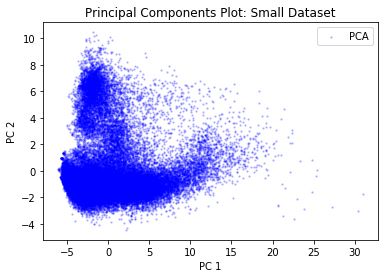

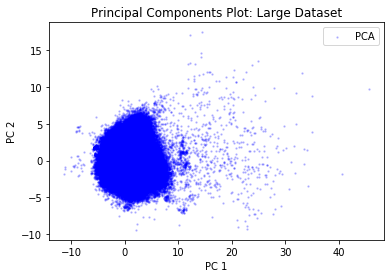

In [8]:
# Plot PCA
plot_pca(pr_comps_1[:,0], pr_comps_1[:,1], "Small Dataset")
plot_pca(pr_comps_2[:,0], pr_comps_2[:,1], "Large Dataset")

In [9]:
# Explained variance by PCA
print('Explained variance by PCA: small dataset:')
print(pca_1.explained_variance_ratio_*100)

print('Explained variance by PCA: large dataset:')
print(pca_2.explained_variance_ratio_*100)

Explained variance by PCA: small dataset:
[21.79083916  6.99218148]
Explained variance by PCA: large dataset:
[6.82614736 5.17513125]


**What do you think about PCA result?**

**Why explained variance by PCA is not high enough on both datasets?**

**Is there any sign of nonlinear relation between variables in the dataset?**

**Time complexity of PCA ($n$ observations, $d$ dimensions)**

- Covariance matrix computation: $O(d^2n)$
- Eigen-value decomposition: $O(d^3)$.
- PCA: $O(d^2n+d^3)$.

## 5. PCA on small and large dataset: GPU

In [10]:
# Nvidia RAPIDS cuML PCA
pca_1 = cumlPCA(n_components = 2)
pca_2 = cumlPCA(n_components = 2)

with Timer("PCA_Small_Dataset"):
    pr_comps_1 = pca_1.fit_transform(small_data)

with Timer("PCA_Large_Dataset"):
    pr_comps_2 = pca_2.fit_transform(large_data)

[PCA_Small_Dataset]
Elapsed: 0.7214851379394531

[PCA_Large_Dataset]
Elapsed: 0.254382848739624



In [11]:
# Explained variance by PCA
print('Explained variance by PCA: small dataset:')
print(pca_1.explained_variance_ratio_*100)

print('Explained variance by PCA: large dataset:')
print(pca_2.explained_variance_ratio_*100)

Explained variance by PCA: small dataset:
0    21.790839
1     6.992182
dtype: float64
Explained variance by PCA: large dataset:
0    6.826147
1    5.175135
dtype: float64


## 6. Introduction to t-SNE

<div style="text-align:center"><img src=https://www.researchgate.net/profile/Lei_Luo6/publication/258392870/figure/fig3/AS:323073124388865@1454038043128/From-a-to-d-a-Swiss-roll-and-its-hash-codes-embedded-to-3D-by-PCA-after-applying.png width="400" title="Source: L. Luo, C. Zhang, Y. Qin, C. Zhang, Mathematical Problems in Engineering 2013" align="center"></div>

**Stochastic Neighbor Embedding**
The goal is to use conditional probabilities to match distributions of distances (Gaussian-distributed) between data points in high and low dimensional space.

![title](img/sne.png)

KL divergence is asymmetric,
- Nearby data points in HD space to widely separated data points in LD space: high cost
- Widely separated data points in HD space to nearby data points in LD space: low cost
- Thus it preserves local structure.
- The $\sigma_i$ is called **perplexity** ~ number of close neighbors of each data points
- Gradient of the cost function in SNE:   
$\frac{\partial C}{\partial y_i} = 2 \sum_j{( p_{j|i} - q_{j|i} + p_{i|j} - q_{i|j} ) ( y_i - y_j )}$

- SNE utilizes Gradient Descent for optimization.
- SNE addes a momentum term: speed up the optimization, avoid local optima   
$y^{(t)} = y^{(t-1)} + \eta \frac{\partial C}{\partial y} + \alpha(t) (y^{(t-1)} - y^{(t-2)})$
- Issues with SNE: difficulty in **optimization of cost function** and **crowding problem**

**How to resolve issues in SNE**?
Symmetric SNE has a symmetric cost function ($p_{i|j}=p_{j|i}$ and $q_{i|j}=q_{j|i}$).

![title](img/tsne.png)

- Gradient of the cost function in symmetric SNE:  
$\frac{\partial C}{\partial y_i} = 4 \sum_j{( p_{ji} - q_{ji} ) ( y_i - y_j )}$


**Another solution to SNE: t-SNE**
- t-SNE stands for **t-Distributed Stochastic Neighbor Embedding**.
- t-SNE is unsupervised and **non-linear** dimensionality reduction technique.
- t-SNE is utilized for data exploration and visualizing **high-dimensional data**.
- t-SNE was developed by *Laurens van der Maatens* and *Geoffrey Hinton* in 2008.
- t-SNE preserves only small pairwise distances or local similarities.
- t-SNE preserves local structure and the global structure [as much as possible].
- PCA preserves large pairwise distances to maximize variance.
- t-SNE computes the similarities between data points in LD space by **Student t-distribution**.
- [Barnes-Hut implementation of t-SNE](https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf) makes the algorithm faster by using a tree structure.

![title](img/tsne2.png)

**t-SNE algorithm**

![title](img/tsne3.png)

**[How to Use t-SNE Effectively](https://distill.pub/2016/misread-tsne/)**

[[t-SNE slides credit](https://github.com/Divyagash)]

## 7. t-SNE on small and large dataset: CPU 

In [12]:
# t-SNE transform
tsne_1 = TSNE(n_components=2, n_jobs=-1, verbose=1)
tsne_2 = TSNE(n_components=2, n_jobs=-1, verbose=1)

with Timer("tSNE_Small_Dataset"):
    tsne_comps_1 = tsne_1.fit_transform(small_data)

# with Timer("tSNE_Large_Dataset"):
#     tsne_comps_2 = tsne_2.fit_transform(large_data)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 42892 samples in 0.349s...
[t-SNE] Computed neighbors for 42892 samples in 218.742s...
[t-SNE] Computed conditional probabilities for sample 1000 / 42892
[t-SNE] Computed conditional probabilities for sample 2000 / 42892
[t-SNE] Computed conditional probabilities for sample 3000 / 42892
[t-SNE] Computed conditional probabilities for sample 4000 / 42892
[t-SNE] Computed conditional probabilities for sample 5000 / 42892
[t-SNE] Computed conditional probabilities for sample 6000 / 42892
[t-SNE] Computed conditional probabilities for sample 7000 / 42892
[t-SNE] Computed conditional probabilities for sample 8000 / 42892
[t-SNE] Computed conditional probabilities for sample 9000 / 42892
[t-SNE] Computed conditional probabilities for sample 10000 / 42892
[t-SNE] Computed conditional probabilities for sample 11000 / 42892
[t-SNE] Computed conditional probabilities for sample 12000 / 42892
[t-SNE] Computed conditional probabilities for s

In [13]:
# t-SNE transform
tsne_1 = mlcoreTSNE(n_components=2, n_jobs=-1, verbose=1)
tsne_2 = mlcoreTSNE(n_components=2, n_jobs=-1, verbose=1)

with Timer("tSNE_Small_Dataset"):
    tsne_comps_1 = tsne_1.fit_transform(small_data)

# with Timer("tSNE_Large_Dataset"):
#     tsne_comps_2 = tsne_2.fit_transform(large_data)

[tSNE_Small_Dataset]
Elapsed: 103.53602266311646



![title](img/tsne_time.png)

![title](img/tsne_speed.png)

## 8. t-SNE on small and large dataset: GPU

In [14]:
tsne_1 = cumlTSNE(n_components=2, verbose=1, method='barnes_hut')
tsne_2 = cumlTSNE(n_components=2, verbose=1, method='barnes_hut')

with Timer("tSNE_Small_Dataset"):
    tsne_comps_1 = tsne_1.fit_transform(small_data)


with Timer("tSNE_Large_Dataset"):
    tsne_comps_2 = tsne_2.fit_transform(large_data)

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 50, learning_rate = 14297.333333333332, exaggeration = 24.0
[tSNE_Small_Dataset]
Elapsed: 2.2934529781341553

Learning rate is adaptive. In TSNE paper, it has been shown that as n->inf, Barnes Hut works well if n_neighbors->30, learning_rate->20000, early_exaggeration->24.
cuML uses an adpative method.n_neighbors decreases to 30 as n->inf. Likewise for the other params.
New n_neighbors = 30, learning_rate = 346677.3333333333, exaggeration = 24.0
[tSNE_Large_Dataset]
Elapsed: 58.560832023620605



**Check GPU utilization**

In [ ]:
!nvidia-smi

![title](img/nvidia_smi.png)